# MODELO DE XGBOOST

librerías necesarias para la implementación del modelo de XGBoost y la visualización de los resultados obtenidos.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report, roc_curve, auc

Carga de los archivos train y test y visualización del conjunto de prueba.

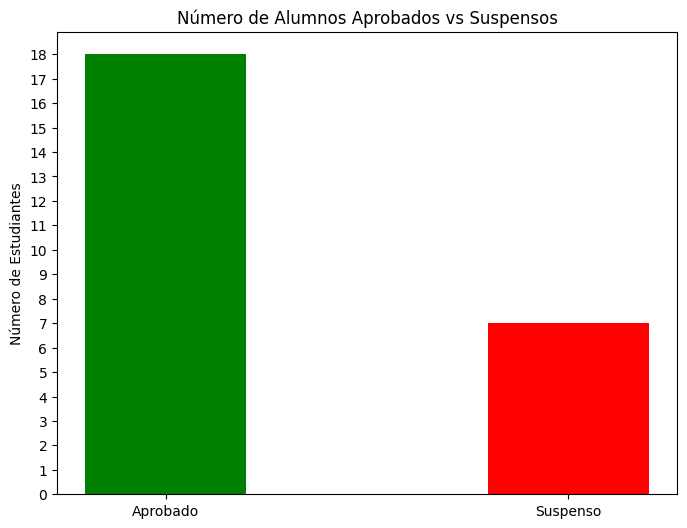

In [25]:
#Carga de los archivos para train y test. Utilizaré los datos de las clases 96, 89 y 81 para entrenar el modelo y para probar el modelo utilizaré los datos de la clase 84
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')

#Visualización de los datos del dataset "test"
#Primero se cuentan los alumnos aprobados y los alumnos suspensos
aprobados = test_data[test_data['nota_final_aprobado'] == 'SI'].shape[0]
suspensos = test_data[test_data['nota_final_aprobado'] == 'NO'].shape[0]

#Creación del gráfico de barras para la visualización de los datos
plt.figure(figsize=(8, 6))
max_value = max(aprobados, suspensos)
plt.yticks(range(0, max_value + 1))
plt.bar('Aprobado', aprobados, width=0.4, color='green')
plt.bar('Suspenso', suspensos, width=0.4, color='red')
plt.title('Número de Alumnos Aprobados vs Suspensos')
plt.ylabel('Número de Estudiantes')
plt.show()

In [26]:
#Visualización de los datos
train_data.head()

,login_est,created,submitted,uploaded,viewed,Friday,Monday,Saturday,Sunday,Thursday,...,diferencia_dias_week1,diferencia_dias_week2,diferencia_dias_week3,diferencia_dias_week4,accesos_week1,accesos_week2,accesos_week3,accesos_week4,wooclap_average,nota_final_aprobado
0,1,0,0,0,80,5,25,18,17,9,...,-1,-1,-1,-1,4,20,6,1,66.666667,NO
1,2,0,0,0,36,0,17,4,2,5,...,-1,-1,-1,-1,4,8,4,1,83.333333,SI
2,3,4,4,4,165,5,18,28,85,41,...,2,6,1,2,3,10,6,4,83.333333,SI
3,4,4,4,4,140,0,8,1,45,31,...,5,5,3,3,2,1,1,1,76.666667,SI
4,5,5,4,5,270,16,59,21,92,66,...,6,5,3,3,6,6,6,4,91.666667,SI


Se obtienen los mejores hiperparámetros a través de una optimización bayesiana

In [27]:
# Se definen las variables independientes X de la variable objetivo Y que será la variable 'nota_final_aprobado' de cada dataframe
encoder = LabelEncoder()
train_data['nota_final_aprobado'] = encoder.fit_transform(train_data['nota_final_aprobado'])
test_data['nota_final_aprobado'] = encoder.transform(test_data['nota_final_aprobado'])

X_train = train_data.drop('nota_final_aprobado', axis=1)
y_train = train_data['nota_final_aprobado']
X_test = test_data.drop('nota_final_aprobado', axis=1)
y_test = test_data['nota_final_aprobado']

# Se normalizan los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función objetivo para Optuna
def objective(trial):
    # Parámetros que se desean optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    # Se define el modelo con los hiperparámetros
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=5,
        eval_metric='logloss',
        random_state=42
    )
    # Entrenamiento del modelo
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Se realiza la optimización con 50 intentos y seed para reproducibilidad
optimizacion = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
optimizacion.optimize(objective, n_trials=50)

# Mejores hiperparámetros encontrados
print("Parámetros del mejor intento:", optimizacion.best_trial.params)
print("Mejor Accuracy del mejor intento:", optimizacion.best_trial.value)

[I 2024-09-05 19:18:08,284] A new study created in memory with name: no-name-fa8638e3-1b41-41d3-a41d-37c7215ede30
C:\Users\david\AppData\Local\Temp\ipykernel_17560\3608062407.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
[I 2024-09-05 19:18:08,368] Trial 0 finished with value: 0.56 and parameters: {'n_estimators': 144, 'learning_rate': 0.2536999076681772}. Best is trial 0 with value: 0.56.
C:\Users\david\AppData\Local\Temp\ipykernel_17560\3608062407.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
[I 2024-09-05 19:18:08,526

Parámetros del mejor intento: {'n_estimators': 92, 'learning_rate': 0.011407797829608154}
Mejor Accuracy del mejor intento: 0.68


In [28]:
XGBoost = xgb.XGBClassifier(n_estimators=80, learning_rate=0.0160, max_depth=5, eval_metric='logloss', random_state=42)
XGBoost.fit(X_train_scaled, y_train)
y_pred = XGBoost.predict(X_test_scaled)

# Se imprime en pantalla el f1-score, accuracy, recall y el classification report
accuracy = accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=False)
print("Accuracy:", accuracy)
print("F1-Score:", score)
print("Recall:", recall)
print("Classification Report\n", class_report)

Accuracy: 0.68
F1-Score: 0.8
Recall: 0.8888888888888888
Classification Report
               precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.73      0.89      0.80        18

    accuracy                           0.68        25
   macro avg       0.53      0.52      0.50        25
weighted avg       0.62      0.68      0.63        25



Visualización y cálculo de la curva ROC del modelo de xgboost.

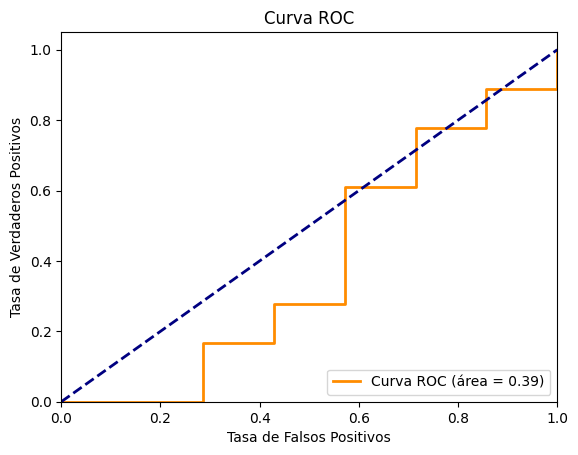

In [29]:
#Se calculan las probabilidades de la curva ROC para calcular la curva ROC y el AUC
y_pred_proba = XGBoost.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#Se imprime la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Visualización de la matriz de confusión con los resultados obtenidos con las predicciones del modelo de xgboost.

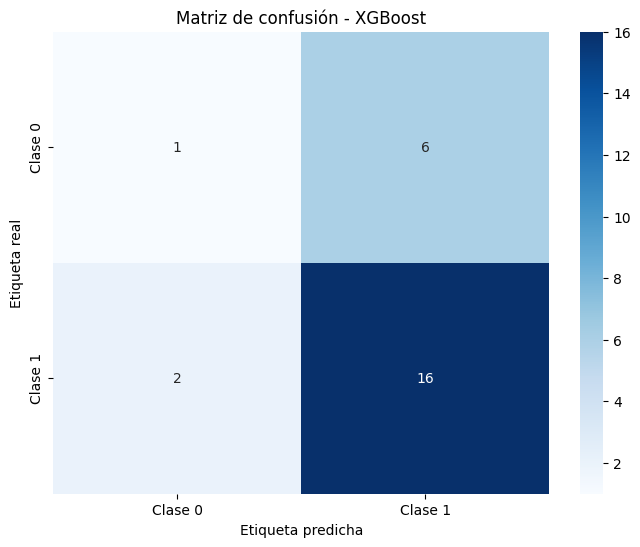

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión - XGBoost')
plt.show()

Se visualiza la comparación entre los valores reales y las predicciones del modelo de xgboost.

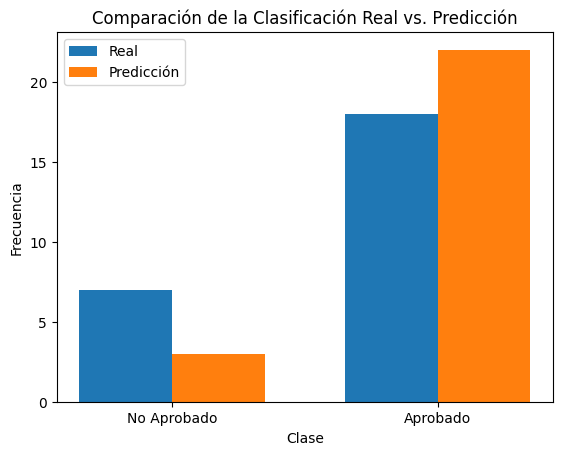

In [31]:
#Se calculan las frecuencias de las clases en los datos reales y predichos
real_class_counts = np.bincount(y_test)
predicted_class_counts = np.bincount(y_pred)

#Se aseguram que los vectores tienen la misma longitud
max_length = max(len(real_class_counts), len(predicted_class_counts))
real_class_counts = np.pad(real_class_counts, (0, max_length - len(real_class_counts)), 'constant')
predicted_class_counts = np.pad(predicted_class_counts, (0, max_length - len(predicted_class_counts)), 'constant')
class_labels = ['No Aprobado', 'Aprobado']

#Creación del diagrama de barras para la visualización de los datos
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(class_labels))
bar1 = ax.bar(index, real_class_counts, bar_width, label='Real')
bar2 = ax.bar(index + bar_width, predicted_class_counts, bar_width, label='Predicción')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
ax.set_title('Comparación de la Clasificación Real vs. Predicción')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_labels)
ax.legend()
plt.show()

paración 1 a 1 de los resultados reales con los resultados predichos.

In [32]:
#Comparación de y_test y y_pred
df_results = pd.concat([y_test, pd.Series(y_pred)], axis = 1)
df_results.rename(columns={'nota_final_aprobado':'y_test', 0:'y_pred'}, inplace=True)
df_results

,y_test,y_pred
0,0,1
1,1,1
2,1,1
3,0,1
4,0,0
5,1,1
6,0,1
7,0,1
8,0,1
9,1,1
